**Scarping and Cleaning the Data**

The goal of this notebook is to scrape arxiv papers that are associated with a [*mathematical subject class*](https://en.wikipedia.org/wiki/Mathematics_Subject_Classification), and clean and preprocess the data which will later be used for a multi-label text classification task. The goal will be to predict the [MSC (Mathematical Subject Classification)](https://mathscinet.ams.org/mathscinet/msc/msc2020.html) classes based on the (cleaned) titles. The full MSC class is a 5-character code, but shorter 2 and 3-character codes are available too. 

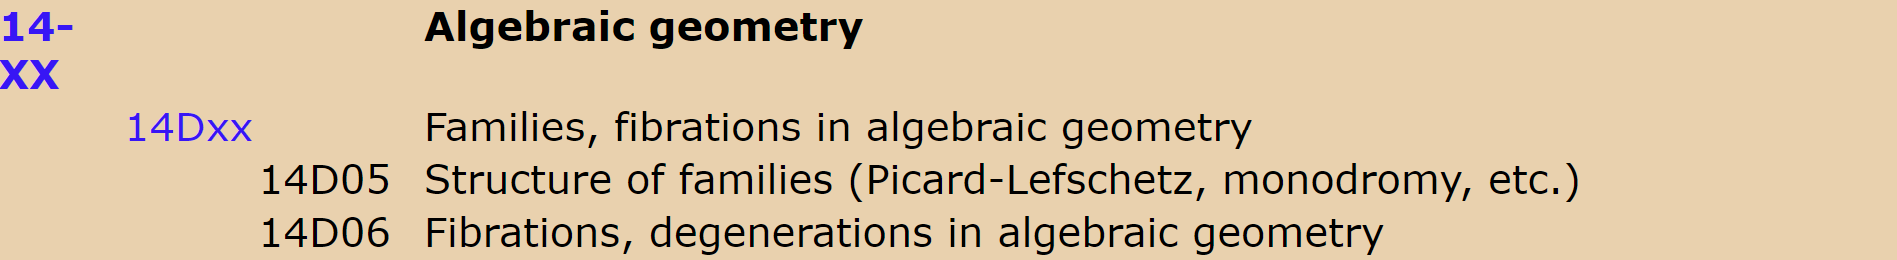

A full 5-character MSC code consists of two digits, an upper case letter and then two other digits. **We shall focus on the 3-character MSC code which has two digits followd by an upper-case letter, e.g. 14D, 37F, 55R80 etc.** First, we import necessary libraries, and we retrieve all such [MSC classes as of 2020](https://zbmath.org/static/msc2020.pdf).  

In [21]:
import pandas as pd
pd.options.mode.chained_assignment = None  #default='warn'  #To avoide SettingWithCopyWarning

from PyPDF2 import PdfReader
import arxiv
import time
from copy import deepcopy
from unidecode import unidecode
import random

#######################################################

reader=PdfReader('./data/msc2020.pdf')                 #Parsing the complete list of MSC2020.
n_pages=len(reader.pages)
df=pd.DataFrame(columns=['class','description'])

#We are interested in 3-character MSC codes. 
#The function below detects them in the form of the head subject, e.g. 14Gxx 
#which itself is divided into more specific topics (MSC codes of length 5).  
def isMSC_xx(string):                        
    if len(string)==5 and string[0:2].isnumeric() and string[2].isupper() and string[3:5]=='xx':
        return True
    return False

for page_number in range(n_pages):
    page_content=reader.pages[page_number].extract_text().split('\n')  #Splitting the page into lines. 
    for line in page_content:
        line_reduced=line.split('[')[0]      #Avoiding expressions such as '[See also...]'
        head=line_reduced.split(' ')[0]
        if isMSC_xx(head):
            MSC=head[:3]
            description=line_reduced.removeprefix(head)
            df.loc[df.shape[0]]=[MSC,description]
df.to_csv('./data/MSCclasses.csv')
print(f'The total number of (2nd level, 3-character) MSC classes is {df.shape[0]}.')
df

The total number of (2nd level, 3-character) MSC classes is 537.


,class,description
0,00A,General and miscellaneous speci c topics
1,00B,Conference proceedings and collections of art...
2,01A,History of mathematics and mathematicians
3,03A,Philosophical aspects of logic and foundations
4,03B,General logic
...,...,...
532,97K,"Education of combinatorics, graph theory, pro..."
533,97M,Education of mathematical modeling and applic...
534,97N,Education of numerical mathematics
535,97P,Computer science (educational aspects)


https://pypi.org/project/arxiv/

https://github.com/lukasschwab/arxiv.py

https://arxiv.org/category_taxonomy

https://info.arxiv.org/help/api/user-manual.html#_details_of_atom_results_returned

Example

In [3]:
import arxiv

# Construct the default API client.
client = arxiv.Client()

#Search for the 50 most recent articles matching the provided category. 
search = arxiv.Search(
  query = "cat:math.AG",
  max_results = 50,
  sort_by = arxiv.SortCriterion.SubmittedDate
)

results = client.results(search)

# `results` is a generator; you can iterate over its elements one by one...
for r in client.results(search):
    print(r.primary_category,r.categories)

math.DG ['math.DG', 'math.AG', 'math.CV', '53C07, 58E15']
math.AG ['math.AG']
math.CO ['math.CO', 'math.AG', 'math.RT', '14T15 (Primary) 05B35, 16G20, 14N20, 14T20 (Secondary)']
math.CT ['math.CT', 'math.AG', 'math.QA', 'math.RA', 'math.RT', '18G80, 18M05 (Primary) 14L30, 16W22, 16T05 (Secondary)']
math.MG ['math.MG', 'math.AG', '14P10, 32V40']
math.SG ['math.SG', 'hep-th', 'math.AG', '53D45, 53D37 (Primary) 14N35, 14N10 (Secondary)']
math.AG ['math.AG', 'math.DS']
math.AG ['math.AG']
hep-th ['hep-th', 'math.AG', 'math.DG', 'math.GT', 'math.SG']
math.AG ['math.AG', 'math.NT']
math.AG ['math.AG', '14D23 (Primary)']
math.AG ['math.AG', '14T10, 13P15, 14-04']
math.AG ['math.AG', 'math.AT']
math.RA ['math.RA', 'math.AG', 'math.PR', '60L10 (Primary) 14P99 17A30 16T05 (Secondary)']
math.NT ['math.NT', 'math.AG', 'math.DS', '11G50, 14J50, 37P15, 37P30']
math.NT ['math.NT', 'math.AG', 'Primary: 14G05, Secondary: 11J25 and 11J97']
math.AC ['math.AC', 'math.AG', 'Primary 13H15, 14C17, 13A30, 14C

In [4]:
math_categories=['math.AC', 'math.AG', 'math.AP', 'math.AT', 'math.CA', 'math.CO', 'math.CT', 'math.CV',
                'math.DG', 'math.DS', 'math.FA', 'math.GM', 'math.GN', 'math.GR', 'math.GT', 'math.HO', 'math.IT',
                'math.KT', 'math.LO', 'math.MG', 'math.MP', 'math.NA', 'math.NT', 'math.OA', 'math.OC', 'math.PR',
                'math.QA', 'math.RA', 'math.RT', 'math.SG', 'math.SP', 'math.ST']
print(f'The number of categories is {len(math_categories)}.')


classes=df['class'].to_list()
print(f'The number of MSC claases is {len(classes)}.')

The number of categories is 32.
The number of MSC claases is 537.


In [5]:
raw_data=pd.DataFrame(columns=['primary_category','title','authors','url','last_updated','MSC'])

In [6]:
time_start=time.time()

# Construct the default API client.
client = arxiv.Client(num_retries=5,page_size=1000,delay_seconds=5)
    
for category in math_categories:
    
    
    #Search for the 9000 most recent articles matching the provided category. 
    search = arxiv.Search(
      query = "cat:"+category,
      max_results = 9000,
      sort_by = arxiv.SortCriterion.SubmittedDate
    )
    
    results = client.results(search)
    
    double_list=list(map(lambda r:[r.primary_category,r.title,r.authors,r.entry_id,r.updated,r.categories[-1]],results))
    
    raw_data=pd.concat([raw_data,
                    pd.DataFrame(double_list,columns=['primary_category','title','authors','url','last_updated','MSC'])]
                   ,ignore_index=True)
    print(f'The category just scraped: {category}, the time elapsed so far: {time.time()-time_start}')

Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2


The category just scraped: math.AC, the time elapsed so far: 159.52551865577698


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2


The category just scraped: math.AG, the time elapsed so far: 344.22815918922424
The category just scraped: math.AP, the time elapsed so far: 460.10070753097534


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2


The category just scraped: math.AT, the time elapsed so far: 626.6334986686707
The category just scraped: math.CA, the time elapsed so far: 742.5147891044617
The category just scraped: math.CO, the time elapsed so far: 857.1029322147369


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2


The category just scraped: math.CT, the time elapsed so far: 996.4865920543671


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2


The category just scraped: math.CV, the time elapsed so far: 1152.1862924098969


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2


The category just scraped: math.DG, the time elapsed so far: 1273.3074259757996
The category just scraped: math.DS, the time elapsed so far: 1384.9960463047028
The category just scraped: math.FA, the time elapsed so far: 1501.8389394283295
The category just scraped: math.GM, the time elapsed so far: 1549.7180032730103
The category just scraped: math.GN, the time elapsed so far: 1625.2145040035248


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2


The category just scraped: math.GR, the time elapsed so far: 1779.7185022830963


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2


The category just scraped: math.GT, the time elapsed so far: 1944.450715303421
The category just scraped: math.HO, the time elapsed so far: 1987.6715829372406
The category just scraped: math.IT, the time elapsed so far: 2116.049647331238


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2


The category just scraped: math.KT, the time elapsed so far: 2229.0596163272858
The category just scraped: math.LO, the time elapsed so far: 2347.1409866809845
The category just scraped: math.MG, the time elapsed so far: 2470.003338098526
The category just scraped: math.MP, the time elapsed so far: 2624.9065799713135
The category just scraped: math.NA, the time elapsed so far: 2750.6530487537384


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2


The category just scraped: math.NT, the time elapsed so far: 2907.761986017227
The category just scraped: math.OA, the time elapsed so far: 3033.9371638298035
The category just scraped: math.OC, the time elapsed so far: 3151.728903055191
The category just scraped: math.PR, the time elapsed so far: 3277.2195296287537
The category just scraped: math.QA, the time elapsed so far: 3395.700026035309
The category just scraped: math.RA, the time elapsed so far: 3519.2553794384003


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2


The category just scraped: math.RT, the time elapsed so far: 3677.766355276108
The category just scraped: math.SG, the time elapsed so far: 3793.5694510936737
The category just scraped: math.SP, the time elapsed so far: 3913.5545201301575
The category just scraped: math.ST, the time elapsed so far: 4048.8049368858337


In [7]:
raw_data.to_csv('raw.csv',index=False)
raw_data

,primary_category,title,authors,url,last_updated,MSC
0,math.AC,Hilbert series and degrees of regularity of Oi...,"[Antonio Corbo Esposito, Rosa Fera, Francesco ...",http://arxiv.org/abs/2311.18626v1,2023-11-30 15:32:01+00:00,math.AC
1,math.AC,Formal lifting of dualizing complexes and cons...,[Shiji Lyu],http://arxiv.org/abs/2311.18196v1,2023-11-30 02:29:02+00:00,math.AC
2,math.AC,Conditions for Virtually Cohen--Macaulay Simpl...,"[Jay Yang, Adam Van Tuyl]",http://arxiv.org/abs/2311.17806v1,2023-11-29 16:55:55+00:00,math.CO
3,math.AC,Density functions for epsilon multiplicity and...,"[Suprajo Das, Sudeshna Roy, Vijaylaxmi Trivedi]",http://arxiv.org/abs/2311.17679v1,2023-11-29 14:41:02+00:00,"Primary 13H15, 14C17, 13A30, 14C20, Secondary ..."
4,math.AC,Conditions of multiplicity and applications fo...,"[Koji Matsushita, Sora Miyashita]",http://arxiv.org/abs/2311.17387v1,2023-11-29 06:35:42+00:00,"Primary 13H10, Secondary 13M05"
...,...,...,...,...,...,...
268764,math.ST,The All-or-Nothing Phenomenon in Sparse Linear...,"[Galen Reeves, Jiaming Xu, Ilias Zadik]",http://arxiv.org/abs/1903.05046v1,2019-03-12 16:53:27+00:00,stat.TH
268765,math.ST,ECKO: Ensemble of Clustered Knockoffs for mult...,"[Tuan-Binh Nguyen, Jérôme-Alexis Chevalier, Be...",http://arxiv.org/abs/1903.04955v1,2019-03-12 14:37:32+00:00,stat.TH
268766,math.ST,Reducing the dimensionality of data using temp...,[Rustem Takhanov],http://arxiv.org/abs/1903.05083v2,2022-11-07 08:55:15+00:00,stat.TH
268767,math.ST,The limits of distribution-free conditional pr...,"[Rina Foygel Barber, Emmanuel J. Candès, Aadit...",http://arxiv.org/abs/1903.04684v2,2020-04-15 00:55:44+00:00,stat.TH


We begin processing the data. We first make a deep copy. Next steps are adding columns for version, arxiv identifier and the year-month of the original upload which can all be retrieved from the url (for the latter one should distinguish betwen pre 2007 style and the current one). 

In [8]:
data=deepcopy(raw_data)
data['version']=data['url'].apply(lambda x:int(x.removeprefix('http://arxiv.org/abs/').split('v')[-1]))
data['identifier']=data['url'].apply(lambda x:x.removeprefix('http://arxiv.org/abs/').split('v')[0])

def extract_year_month(identifier):
    if len(identifier.split('.')[0])==4:
        return identifier.split('.')[0][:2]+'-'+identifier.split('.')[0][2:]
    else:
        return identifier.split('/')[1][:2]+'-'+identifier.split('/')[1][2:4]    
data['year_month']=data['identifier'].apply(extract_year_month)
data

,primary_category,title,authors,url,last_updated,MSC,version,identifier,year_month
0,math.AC,Hilbert series and degrees of regularity of Oi...,"[Antonio Corbo Esposito, Rosa Fera, Francesco ...",http://arxiv.org/abs/2311.18626v1,2023-11-30 15:32:01+00:00,math.AC,1,2311.18626,23-11
1,math.AC,Formal lifting of dualizing complexes and cons...,[Shiji Lyu],http://arxiv.org/abs/2311.18196v1,2023-11-30 02:29:02+00:00,math.AC,1,2311.18196,23-11
2,math.AC,Conditions for Virtually Cohen--Macaulay Simpl...,"[Jay Yang, Adam Van Tuyl]",http://arxiv.org/abs/2311.17806v1,2023-11-29 16:55:55+00:00,math.CO,1,2311.17806,23-11
3,math.AC,Density functions for epsilon multiplicity and...,"[Suprajo Das, Sudeshna Roy, Vijaylaxmi Trivedi]",http://arxiv.org/abs/2311.17679v1,2023-11-29 14:41:02+00:00,"Primary 13H15, 14C17, 13A30, 14C20, Secondary ...",1,2311.17679,23-11
4,math.AC,Conditions of multiplicity and applications fo...,"[Koji Matsushita, Sora Miyashita]",http://arxiv.org/abs/2311.17387v1,2023-11-29 06:35:42+00:00,"Primary 13H10, Secondary 13M05",1,2311.17387,23-11
...,...,...,...,...,...,...,...,...,...
268764,math.ST,The All-or-Nothing Phenomenon in Sparse Linear...,"[Galen Reeves, Jiaming Xu, Ilias Zadik]",http://arxiv.org/abs/1903.05046v1,2019-03-12 16:53:27+00:00,stat.TH,1,1903.05046,19-03
268765,math.ST,ECKO: Ensemble of Clustered Knockoffs for mult...,"[Tuan-Binh Nguyen, Jérôme-Alexis Chevalier, Be...",http://arxiv.org/abs/1903.04955v1,2019-03-12 14:37:32+00:00,stat.TH,1,1903.04955,19-03
268766,math.ST,Reducing the dimensionality of data using temp...,[Rustem Takhanov],http://arxiv.org/abs/1903.05083v2,2022-11-07 08:55:15+00:00,stat.TH,2,1903.05083,19-03
268767,math.ST,The limits of distribution-free conditional pr...,"[Rina Foygel Barber, Emmanuel J. Candès, Aadit...",http://arxiv.org/abs/1903.04684v2,2020-04-15 00:55:44+00:00,stat.TH,2,1903.04684,19-03


Removing some outrageous titles.

In [9]:
data.sort_values(by=['version'],ascending=False).head(40)

,primary_category,title,authors,url,last_updated,MSC,version,identifier,year_month
99750,math.GM,The lost proof of Fermat's last theorem,[Andrea Ossicini],http://arxiv.org/abs/1704.06335v73,2022-11-28 07:38:50+00:00,"11D41 (primary), 11G05 (secondary)",73,1704.06335,17-04
101164,math.GM,A certain continuity property of the residues ...,[Hisanobu Shinya],http://arxiv.org/abs/0706.0357v67,2023-11-18 08:31:02+00:00,11M26,67,0706.0357,07-06
100871,math.GM,High Degree Diophantine Equation c^q=a^p+b^p,[Sheng-Ping Wu],http://arxiv.org/abs/0809.2293v64,2021-01-07 05:28:18+00:00,"11D41 (Primary), 13M10 (Secondary)",64,0809.2293,08-09
100283,math.GM,On the nature of Mersenne fluctuations,[U. Merkel],http://arxiv.org/abs/1309.5272v47,2023-03-03 12:36:40+00:00,math.GM,47,1309.5272,13-09
99181,math.GM,A lower bound for the modulus of the Dirichlet...,[Yuri Heymann],http://arxiv.org/abs/2002.04395v47,2023-09-27 11:00:00+00:00,"11M26, 11Axx",47,2002.04395,20-02
232148,math.AG,Generalizations of local bijectivity of Keller...,[Yucai Su],http://arxiv.org/abs/1603.01867v42,2023-09-03 05:06:30+00:00,"14R15, 14E20, 13B10, 13B25, 17B63",42,1603.01867,16-03
5827,math.AG,Generalizations of local bijectivity of Keller...,[Yucai Su],http://arxiv.org/abs/1603.01867v42,2023-09-03 05:06:30+00:00,"14R15, 14E20, 13B10, 13B25, 17B63",42,1603.01867,16-03
100712,math.GM,Theorems on twin primes-dual case,[Vladimir Shevelev],http://arxiv.org/abs/0912.4006v37,2014-08-31 11:15:43+00:00,11A41,37,0912.4006,09-12
98638,math.GM,Non trivial zeros of the Zeta function using t...,[Walid Oukil],http://arxiv.org/abs/2112.05521v34,2023-11-24 17:01:39+00:00,math.GM,34,2112.05521,21-12
101449,math.GM,An analytic proof of Fermat-Wiles theorem !,[Jamel Ghanouchi],http://arxiv.org/abs/math/0510081v32,2006-01-07 17:55:31+00:00,math.GM,32,math/0510081,05-10


Removing all versions of any preprint with more than 10 versions.

In [10]:
too_many_v_list=data.index[data['version']>10].to_list()
bad_identifiers=set(data.loc[too_many_v_list,'identifier'])
data=data[data['identifier'].apply(lambda identifier:identifier not in bad_identifiers)]
data=data.sort_values(by=['version'],ascending=False,ignore_index=True)
data

,primary_category,title,authors,url,last_updated,MSC,version,identifier,year_month
0,math.CT,Singularity categories of locally bounded cate...,[Ales M. Bouhada],http://arxiv.org/abs/1901.05087v10,2019-08-21 20:51:14+00:00,"16E35, 16G20, 16G70, 18E30, 18E35",10,1901.05087,19-01
1,math.RT,Regularity and stable ranges of FI-modules,[Cihan Bahran],http://arxiv.org/abs/2203.06698v10,2023-05-25 19:05:23+00:00,"18A25, 05E10 (primary) 55R80, 11F75 (secondary)",10,2203.06698,22-03
2,math.RT,Regularity and stable ranges of FI-modules,[Cihan Bahran],http://arxiv.org/abs/2203.06698v10,2023-05-25 19:05:23+00:00,"18A25, 05E10 (primary) 55R80, 11F75 (secondary)",10,2203.06698,22-03
3,math.SG,Invariance of immersed Floer cohomology under ...,"[Joseph Palmer, Chris Woodward]",http://arxiv.org/abs/1903.01943v10,2023-07-05 20:49:43+00:00,53D40,10,1903.01943,19-03
4,math.GM,Eight-dimensional Octonion-like but Associativ...,[Joy Christian],http://arxiv.org/abs/1908.06172v10,2022-11-21 02:57:16+00:00,quant-ph,10,1908.06172,19-08
...,...,...,...,...,...,...,...,...,...
268517,math.CO,Flag-transitive non-symmetric $2$-designs with...,"[Yongli Zhang, Shenglin Zhou]",http://arxiv.org/abs/1907.06425v1,2019-07-15 10:53:12+00:00,math.GR,1,1907.06425,19-07
268518,math.GT,Envelopes in Outer Space,[Christian Steinhart],http://arxiv.org/abs/1907.06402v1,2019-07-15 09:53:32+00:00,"20E08, 20E36, 51H99",1,1907.06402,19-07
268519,math.AT,Depth and detection for Noetherian unstable al...,[Drew Heard],http://arxiv.org/abs/1907.06373v1,2019-07-15 08:54:03+00:00,math.GR,1,1907.06373,19-07
268520,math.CO,On decomposing complete tripartite graphs into...,"[M. Abdolmaleki, S. Gh. Ilchi, E. S. Mahmoodia...",http://arxiv.org/abs/1907.06187v1,2019-07-14 08:30:28+00:00,math.GR,1,1907.06187,19-07


Keeping only the oldest version

In [11]:
data.drop_duplicates(subset=['identifier'],keep='first',inplace=True,ignore_index=True)
data

,primary_category,title,authors,url,last_updated,MSC,version,identifier,year_month
0,math.CT,Singularity categories of locally bounded cate...,[Ales M. Bouhada],http://arxiv.org/abs/1901.05087v10,2019-08-21 20:51:14+00:00,"16E35, 16G20, 16G70, 18E30, 18E35",10,1901.05087,19-01
1,math.RT,Regularity and stable ranges of FI-modules,[Cihan Bahran],http://arxiv.org/abs/2203.06698v10,2023-05-25 19:05:23+00:00,"18A25, 05E10 (primary) 55R80, 11F75 (secondary)",10,2203.06698,22-03
2,math.SG,Invariance of immersed Floer cohomology under ...,"[Joseph Palmer, Chris Woodward]",http://arxiv.org/abs/1903.01943v10,2023-07-05 20:49:43+00:00,53D40,10,1903.01943,19-03
3,math.GM,Eight-dimensional Octonion-like but Associativ...,[Joy Christian],http://arxiv.org/abs/1908.06172v10,2022-11-21 02:57:16+00:00,quant-ph,10,1908.06172,19-08
4,math.OA,Dense nuclear Fréchet ideals in $C^\star$-alge...,[Larry B. Schweitzer],http://arxiv.org/abs/1205.0089v10,2015-10-30 06:32:27+00:00,"46H20, 46H10, 46A11, 46A45, 46L87",10,1205.0089,12-05
...,...,...,...,...,...,...,...,...,...
212911,math.GR,Strictly systolic angled complexes and hyperbo...,"[Martin Axel Blufstein, Elias Gabriel Minian]",http://arxiv.org/abs/1907.06738v1,2019-07-15 20:36:13+00:00,"20F67, 20F65, 20F06, 57M07, 57M20",1,1907.06738,19-07
212912,math.GR,"The local structure theorem, the non-character...","[Chris Parker, Gernot Stroth]",http://arxiv.org/abs/1907.06460v1,2019-07-15 12:16:37+00:00,math.GR,1,1907.06460,19-07
212913,math.CO,Flag-transitive non-symmetric $2$-designs with...,"[Yongli Zhang, Shenglin Zhou]",http://arxiv.org/abs/1907.06425v1,2019-07-15 10:53:12+00:00,math.GR,1,1907.06425,19-07
212914,math.CO,On decomposing complete tripartite graphs into...,"[M. Abdolmaleki, S. Gh. Ilchi, E. S. Mahmoodia...",http://arxiv.org/abs/1907.06187v1,2019-07-14 08:30:28+00:00,math.GR,1,1907.06187,19-07


There are many preprints for which the authors have not specified MSC classes. Those will be dropped. For the rest, we keep the first three characters of any MSC entered in a new column. 

In [12]:
def isFullMSC(string):                        #Is the string a full MSC string, e.g. 20E18.        
    if len(string)==5 and string[0:2].isnumeric() and string[2].isupper() and string[0:2].isnumeric():
        return True
    return False

def extractMSC(FullMSC_all):                  #Detecting terms of the form 16Rxx and returning the first three characters.
    terms=FullMSC_all.split(' ')              #Each term ends with ',' or ',\n'
    return list(set([term.strip('\n').strip(',')[0:3] for term in terms if isFullMSC(term.strip('\n').strip(','))]))
        
data['MSC']=data['MSC'].apply(extractMSC)
data=data[data['MSC'].apply(lambda x:len(x)>0)]
data=data.sort_values(by=['primary_category'],ignore_index=True)   #Sorting based on the primary category.
data

,primary_category,title,authors,url,last_updated,MSC,version,identifier,year_month
0,astro-ph.CO,After the Dark Ages,[Jürg Fröhlich],http://arxiv.org/abs/2205.11929v1,2022-05-24 09:43:48+00:00,[83F],1,2205.11929,22-05
1,astro-ph.EP,On Asteroid Retrieval Missions Enabled by Inva...,"[Jack Tyler, Alexander Wittig]",http://arxiv.org/abs/2101.07610v2,2021-03-22 15:00:35+00:00,"[49K, 70F]",2,2101.07610,21-01
2,astro-ph.EP,Relative Equilibria and Periodic Orbits in a B...,"[Lennard F. Bakker, Nicholas J. Freeman]",http://arxiv.org/abs/2306.00273v1,2023-06-01 01:21:10+00:00,"[70F, 37C]",1,2306.00273,23-06
3,astro-ph.EP,Three-dimensional Lagrangian Coherent Structur...,"[Jack Tyler, Alexander Wittig]",http://arxiv.org/abs/2209.11561v1,2022-09-23 12:36:12+00:00,[70F],1,2209.11561,22-09
4,astro-ph.EP,A Small Variation of the Circular Hodograph Th...,"[Carman Cater, Oscar Perdomo, Amanda Valentine]",http://arxiv.org/abs/2109.11664v1,2021-09-23 22:08:10+00:00,[70M],1,2109.11664,21-09
...,...,...,...,...,...,...,...,...,...
101305,stat.ML,Sparse Popularity Adjusted Stochastic Block Model,"[Majid Noroozi, Marianna Pensky, Ramchandra Ri...",http://arxiv.org/abs/1910.01931v3,2021-10-07 02:29:52+00:00,"[62F, 05C, 62H]",3,1910.01931,19-10
101306,stat.OT,Anna Karenina and The Two Envelopes Problem,[R. D. Gill],http://arxiv.org/abs/2003.04008v5,2022-05-27 09:02:08+00:00,[97K],5,2003.04008,20-03
101307,stat.OT,The Geometry of Chi-Square Degrees of Freedom,[James Bernhard],http://arxiv.org/abs/2305.10335v1,2023-05-17 16:19:37+00:00,"[62E, 60E]",1,2305.10335,23-05
101308,stat.OT,A Brief History of the Statistics Department o...,"[Terry Speed, Jim Pitman, John Rice]",http://arxiv.org/abs/1201.6450v1,2012-01-31 05:54:46+00:00,[01A],1,1201.6450,12-01


We begin cleaning the titles. The first step is to make them lower case and remove the stopwords. 

In [13]:
data['cleaned_title']=data['title']

#The stopwords in our list are lower case, so we first make everything lower case. 
data['cleaned_title']=data['cleaned_title'].apply(lambda title:title.lower())

# import nltk
# nltk.download('stopwords')          #Uncomment if necessary
from nltk.corpus import stopwords
STOPWORDS = list(stopwords.words('english'))

def remove_stop_words(string):
    cleaned_string=''
    terms=string.split(' ')
    for term in terms:
        if term in STOPWORDS:
            cleaned_string+=' '
        else:
            cleaned_string+=' '+term
    return cleaned_string

data['cleaned_title']=data['cleaned_title'].apply(remove_stop_words)

Occasionally, LaTeX math environment has been used in the titles. We are going to remove all those parts which are between `$` signs.   

In [14]:
def remove_math(string):
    terms=string.split('$')
    if terms[0]=='' and terms[-1]=='' and len(terms)==3:   #I.e. the whole title is in the math environment. 
        return ''
    
    cleaned_string=''                  #Initializing
    between_dollar_signs=False        
    for term in terms:
        if not between_dollar_signs:
            cleaned_string+=term
            between_dollar_signs=True  #The next term will be between dollar signs
        else:
            between_dollar_signs=False
    return cleaned_string

data['cleaned_title']=data['cleaned_title'].apply(remove_math)

data=data[data['cleaned_title']!='']  #Records where the title is entirely in the math environment are removed. 
data

,primary_category,title,authors,url,last_updated,MSC,version,identifier,year_month,cleaned_title
0,astro-ph.CO,After the Dark Ages,[Jürg Fröhlich],http://arxiv.org/abs/2205.11929v1,2022-05-24 09:43:48+00:00,[83F],1,2205.11929,22-05,dark ages
1,astro-ph.EP,On Asteroid Retrieval Missions Enabled by Inva...,"[Jack Tyler, Alexander Wittig]",http://arxiv.org/abs/2101.07610v2,2021-03-22 15:00:35+00:00,"[49K, 70F]",2,2101.07610,21-01,asteroid retrieval missions enabled invaria...
2,astro-ph.EP,Relative Equilibria and Periodic Orbits in a B...,"[Lennard F. Bakker, Nicholas J. Freeman]",http://arxiv.org/abs/2306.00273v1,2023-06-01 01:21:10+00:00,"[70F, 37C]",1,2306.00273,23-06,relative equilibria periodic orbits binary...
3,astro-ph.EP,Three-dimensional Lagrangian Coherent Structur...,"[Jack Tyler, Alexander Wittig]",http://arxiv.org/abs/2209.11561v1,2022-09-23 12:36:12+00:00,[70F],1,2209.11561,22-09,three-dimensional lagrangian coherent structu...
4,astro-ph.EP,A Small Variation of the Circular Hodograph Th...,"[Carman Cater, Oscar Perdomo, Amanda Valentine]",http://arxiv.org/abs/2109.11664v1,2021-09-23 22:08:10+00:00,[70M],1,2109.11664,21-09,small variation circular hodograph theorem...
...,...,...,...,...,...,...,...,...,...,...
101305,stat.ML,Sparse Popularity Adjusted Stochastic Block Model,"[Majid Noroozi, Marianna Pensky, Ramchandra Ri...",http://arxiv.org/abs/1910.01931v3,2021-10-07 02:29:52+00:00,"[62F, 05C, 62H]",3,1910.01931,19-10,sparse popularity adjusted stochastic block m...
101306,stat.OT,Anna Karenina and The Two Envelopes Problem,[R. D. Gill],http://arxiv.org/abs/2003.04008v5,2022-05-27 09:02:08+00:00,[97K],5,2003.04008,20-03,anna karenina two envelopes problem
101307,stat.OT,The Geometry of Chi-Square Degrees of Freedom,[James Bernhard],http://arxiv.org/abs/2305.10335v1,2023-05-17 16:19:37+00:00,"[62E, 60E]",1,2305.10335,23-05,geometry chi-square degrees freedom
101308,stat.OT,A Brief History of the Statistics Department o...,"[Terry Speed, Jim Pitman, John Rice]",http://arxiv.org/abs/1201.6450v1,2012-01-31 05:54:46+00:00,[01A],1,1201.6450,12-01,brief history statistics department univ...


Next, removing special characters and accents. 

In [15]:
def modify(string):
    
    #The following characters will be removed.
    
    string=string.translate({ord(i): None for i in ":;,!?.'(){}`[]/*^$"})
    
    string=string.translate({ord(i): None for i in '"'})  #The signle quote was removed above. Here the double quote will be removed as well.
    
    
    #The following characters will be replaced with space.
    temp2="-=&+\n"                                
    string=string.translate({ord(i): ' ' for i in "-=&+"}) 
    
    return string

data['cleaned_title']=data['cleaned_title'].apply(modify)

data['cleaned_title']=data['cleaned_title'].apply(lambda string:unidecode(string))
data

,primary_category,title,authors,url,last_updated,MSC,version,identifier,year_month,cleaned_title
0,astro-ph.CO,After the Dark Ages,[Jürg Fröhlich],http://arxiv.org/abs/2205.11929v1,2022-05-24 09:43:48+00:00,[83F],1,2205.11929,22-05,dark ages
1,astro-ph.EP,On Asteroid Retrieval Missions Enabled by Inva...,"[Jack Tyler, Alexander Wittig]",http://arxiv.org/abs/2101.07610v2,2021-03-22 15:00:35+00:00,"[49K, 70F]",2,2101.07610,21-01,asteroid retrieval missions enabled invaria...
2,astro-ph.EP,Relative Equilibria and Periodic Orbits in a B...,"[Lennard F. Bakker, Nicholas J. Freeman]",http://arxiv.org/abs/2306.00273v1,2023-06-01 01:21:10+00:00,"[70F, 37C]",1,2306.00273,23-06,relative equilibria periodic orbits binary...
3,astro-ph.EP,Three-dimensional Lagrangian Coherent Structur...,"[Jack Tyler, Alexander Wittig]",http://arxiv.org/abs/2209.11561v1,2022-09-23 12:36:12+00:00,[70F],1,2209.11561,22-09,three dimensional lagrangian coherent structu...
4,astro-ph.EP,A Small Variation of the Circular Hodograph Th...,"[Carman Cater, Oscar Perdomo, Amanda Valentine]",http://arxiv.org/abs/2109.11664v1,2021-09-23 22:08:10+00:00,[70M],1,2109.11664,21-09,small variation circular hodograph theorem...
...,...,...,...,...,...,...,...,...,...,...
101305,stat.ML,Sparse Popularity Adjusted Stochastic Block Model,"[Majid Noroozi, Marianna Pensky, Ramchandra Ri...",http://arxiv.org/abs/1910.01931v3,2021-10-07 02:29:52+00:00,"[62F, 05C, 62H]",3,1910.01931,19-10,sparse popularity adjusted stochastic block m...
101306,stat.OT,Anna Karenina and The Two Envelopes Problem,[R. D. Gill],http://arxiv.org/abs/2003.04008v5,2022-05-27 09:02:08+00:00,[97K],5,2003.04008,20-03,anna karenina two envelopes problem
101307,stat.OT,The Geometry of Chi-Square Degrees of Freedom,[James Bernhard],http://arxiv.org/abs/2305.10335v1,2023-05-17 16:19:37+00:00,"[62E, 60E]",1,2305.10335,23-05,geometry chi square degrees freedom
101308,stat.OT,A Brief History of the Statistics Department o...,"[Terry Speed, Jim Pitman, John Rice]",http://arxiv.org/abs/1201.6450v1,2012-01-31 05:54:46+00:00,[01A],1,1201.6450,12-01,brief history statistics department univ...


Looking at the titles which still have special characters. 

In [16]:
def special_character_detection(string):
    terms=string.split(' ')
    for term in terms:
        if len(term)==0:             #A space at the end or beginning is okay
            continue
        if not term.isalnum():
            return True
    return False

print('The number of removed records:',data[data['cleaned_title'].apply(lambda title:special_character_detection(title))].shape[0])
data=data[data['cleaned_title'].apply(lambda title:not special_character_detection(title))]
data

The number of removed records: 561


,primary_category,title,authors,url,last_updated,MSC,version,identifier,year_month,cleaned_title
0,astro-ph.CO,After the Dark Ages,[Jürg Fröhlich],http://arxiv.org/abs/2205.11929v1,2022-05-24 09:43:48+00:00,[83F],1,2205.11929,22-05,dark ages
1,astro-ph.EP,On Asteroid Retrieval Missions Enabled by Inva...,"[Jack Tyler, Alexander Wittig]",http://arxiv.org/abs/2101.07610v2,2021-03-22 15:00:35+00:00,"[49K, 70F]",2,2101.07610,21-01,asteroid retrieval missions enabled invaria...
2,astro-ph.EP,Relative Equilibria and Periodic Orbits in a B...,"[Lennard F. Bakker, Nicholas J. Freeman]",http://arxiv.org/abs/2306.00273v1,2023-06-01 01:21:10+00:00,"[70F, 37C]",1,2306.00273,23-06,relative equilibria periodic orbits binary...
3,astro-ph.EP,Three-dimensional Lagrangian Coherent Structur...,"[Jack Tyler, Alexander Wittig]",http://arxiv.org/abs/2209.11561v1,2022-09-23 12:36:12+00:00,[70F],1,2209.11561,22-09,three dimensional lagrangian coherent structu...
4,astro-ph.EP,A Small Variation of the Circular Hodograph Th...,"[Carman Cater, Oscar Perdomo, Amanda Valentine]",http://arxiv.org/abs/2109.11664v1,2021-09-23 22:08:10+00:00,[70M],1,2109.11664,21-09,small variation circular hodograph theorem...
...,...,...,...,...,...,...,...,...,...,...
101305,stat.ML,Sparse Popularity Adjusted Stochastic Block Model,"[Majid Noroozi, Marianna Pensky, Ramchandra Ri...",http://arxiv.org/abs/1910.01931v3,2021-10-07 02:29:52+00:00,"[62F, 05C, 62H]",3,1910.01931,19-10,sparse popularity adjusted stochastic block m...
101306,stat.OT,Anna Karenina and The Two Envelopes Problem,[R. D. Gill],http://arxiv.org/abs/2003.04008v5,2022-05-27 09:02:08+00:00,[97K],5,2003.04008,20-03,anna karenina two envelopes problem
101307,stat.OT,The Geometry of Chi-Square Degrees of Freedom,[James Bernhard],http://arxiv.org/abs/2305.10335v1,2023-05-17 16:19:37+00:00,"[62E, 60E]",1,2305.10335,23-05,geometry chi square degrees freedom
101308,stat.OT,A Brief History of the Statistics Department o...,"[Terry Speed, Jim Pitman, John Rice]",http://arxiv.org/abs/1201.6450v1,2012-01-31 05:54:46+00:00,[01A],1,1201.6450,12-01,brief history statistics department univ...


In [17]:
data.to_csv('processed.csv',index=False)